In [50]:
#####################
# Aleksandr Ukhatov #
#####################

# imports 
import os
import sys
import cv2
import ntpath
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob

from shutil import copyfile
import multiprocessing as mp
from multiprocessing import Pool

In [51]:
class ResultError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [52]:
# find matches between to given images
# inputs are image names
def match_imgs(img1, img2_name, show=False):
    
#     MIN_MATCH_COUNT = 70

    # read images 
#     img1 = cv2.imread(img1_name,0) # queryImage
    img2 = cv2.imread(img2_name,0) # trainImage

    # Initiate SIFT detector
    # sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    if show:
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

        else:
            print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

            matchesMask = None

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None,
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)

        img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

        plt.imshow(img3, 'gray'),plt.show()
    
    # return number of good matches
    return len(good)

In [53]:
# get target frames, with target object/car   
def get_target_frames(project_dir, img1_name, folder_to="target", folder_from="images"):
    # init constants
    MIN_MATCH_COUNT = 70
    
    # make folder for target images
    os.system("mkdir " + project_dir + folder_to)
    # get name of target/query image 
    img1_name = ntpath.dirname(project_dir[:-1]) + "/" + img1_name
    # get names of images which might become target
    cropped_imgs =  sorted(glob.glob(project_dir + folder_from + "/*.jpg"))
    goodness = []
    
    # use multiprocessing 
#     pool = mp.Pool(mp.cpu_count())
    # find number of matches of all images with target/query image
    img1 = cv2.imread(img1_name,0)
#     goodness = [pool.apply(match_imgs, args=(img1_name, img)) for img in cropped_imgs]
    for img in cropped_imgs:
        goodness.append(match_imgs(img1, img))
    
    max_goodness = max(goodness)
    if max_goodness < MIN_MATCH_COUNT:
        print("Max goodness is " + str(max_goodness))
        print("There is no target car in the input video " + ntpath.basename(project_dir[:-1]) + ".mp4")
        return 
    
    best_index = goodness.index(max_goodness)
    new_file_name = project_dir + folder_to + "/" + ntpath.basename(cropped_imgs[best_index])
    copyfile(cropped_imgs[best_index], new_file_name)
    
    return new_file_name


In [54]:
def video_to_frames(video_file, pr_dir=0):
    # init constants
    scale = 0.5
    ms = 200
    place = "data/projects2/"
    
    print(video_file)

    # init project directory
    video_name = ((ntpath.basename(video_file)).split("."))[0]
    os.system("mkdir " + place)
    os.system("mkdir " + place +  video_name)
    os.system("mkdir "+ place + video_name + "/images")
    # save current project directory name
    project_dir = os.getcwd() + "/" + place + video_name + "/" 
    if pr_dir:
        return project_dir
    
    count = 1
    # read image
    vidcap = cv2.VideoCapture(video_file)
    # read first image
    success, image = vidcap.read()
    while success:
#         print('Read a new frame #' + str(count))
        # resize image
        dim = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        # save image
        cv2.imwrite(project_dir + "images/" + video_name + "_frame_" + str(count).zfill(3) + ".jpg", image)     # save frame as JPEG file      
        # read new image
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*ms))
        success, image = vidcap.read()
        # increase count
        count += 1  
        # limitations
        if count > 50:
            break 
    print("Obtained " + str(count-1) + " images")
    # return current project directory
    return project_dir

In [73]:
def match_n_images(frames, show=False):
        
    MIN_MATCH_COUNT = 70
    
    len_frames = len(frames)
    # read images 
    imgs = []
    for frame in frames:
        imgs.append(cv2.imread(frame,0)) # queryImage

    # Initiate SIFT detector
    # sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kps = []
    dess = []
    for img in imgs:
        kp, des = sift.detectAndCompute(img,None)
        kps.append(kp)
        dess.append(des)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = {}
    num_matches = {}
    for i in range(len_frames):
        matches[i] = {} 
        num_matches[i] = {}
        for j in range(len_frames-i-1):
            j += i + 1
            if j >= len_frames:
                break
            matches[i][j] = flann.knnMatch(dess[i],dess[j],k=2)

            # store all the good matches as per Lowe's ratio test.
            good = []
            for m,n in matches[i][j]:
                if m.distance < 0.7*n.distance:
                    good.append(m)

            num_matches[i][j] = len(good)
            
            if show:
                if len(good)>MIN_MATCH_COUNT:
                    src_pts = np.float32([ kps[i][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
                    dst_pts = np.float32([ kps[j][m.trainIdx].pt for m in good ]).reshape(-1,1,2)

                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
                    matchesMask = mask.ravel().tolist()

                    h,w = imgs[i].shape
                    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                    dst = cv2.perspectiveTransform(pts,M)

                    img2 = cv2.polylines(imgs[j],[np.int32(dst)],True,255,3, cv2.LINE_AA)

                else:
                    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

                    matchesMask = None

                draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                                   singlePointColor = None,
                                   matchesMask = matchesMask, # draw only inliers
                                   flags = 2)

                img3 = cv2.drawMatches(imgs[i],kps[i],img2,kps[j] ,good,None,**draw_params)

                plt.imshow(img3, 'gray'),plt.show()

            # return number of good matches
    return num_matches

In [63]:
ROOT_DIR = os.getcwd()
while ((list(filter(bool, ROOT_DIR.split("/"))))[-1] != "distances"):
    os.chdir('..')
    ROOT_DIR = os.getcwd()
video_files = []
project_dirs = []
target_frames = []
video_files.append("/Users/ukhatov/Documents/Projects/distances/data/videos/20190816_134744.mp4")
video_files.append("/Usersa/ukhatov/Documents/Projects/distances/data/videos/20190816_135049.mp4")
for video_file in video_files:
    project_dirs.append(video_to_frames(video_file))
    target_frames += [get_target_frames(project_dirs[-1], "target.jpg", "target", "images")]
    print("video is done")

/Users/ukhatov/Documents/Projects/distances/data/videos/20190816_134744.mp4
Obtained 47 images
video is done
/Users/ukhatov/Documents/Projects/distances/data/videos/20190816_135049.mp4
Obtained 50 images
video is done


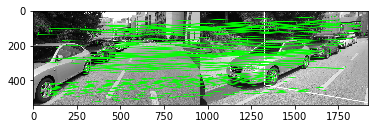

In [74]:
matches = match_n_images(target_frames, show=True)

In [75]:
matches

{0: {1: 245}, 1: {}}